# Machine Learning Mini Project

# 1 Author

**Student Name**:  Jianqi Hui

**Student ID**:  221170685

**GitHub Repository**: https://github.com/FrostHex/Course_Machine_Learning_Task



# 2 Problem formulation

The dataset consist of labelled audio recordings of storytelling. Each audio recording will consist of a story describing a personal experience. Each story might be a true recount or a false recount. Our model need to formulate a method to distinguish whether it's a true story or a deceptive story. 

The interesting aspect of this task lies in its application of machine learning techniques to the domain of audio processing and natural language understanding. The project aims to develop a model capable of discerning the veracity of personal stories. This involves a combination of signal processing, feature extraction, and the implementation of various machine learning algorithms, making it a multifaceted and challenging problem. Additionally, the task has practical implications in areas such as forensic analysis, psychology, and security, where distinguishing between truthful and deceptive statements is crucial.

# 3 Methodology

My methodolgy is to split the training dataset and validation datatest into a ratio of 8:2, with random choice of allocation where the random seed is associated with the time, so it will maximize the degree of random, to try my best to eliminate the influence of the choice of datasets on the model training process.

As for the training and validation model, I will try to use logistic regression and k-means.

I will judge my model manly on the accuracy, and also the confusion matrix, and alos include the precision, recall and f1-score.

# 4 Implemented ML prediction pipelines

The first stage of my pipeline is to preprocess the audio file using librosa library to convert the audio file into several arrays of float numbers. Then I will use the librosa library to perform the feature extraction, and then implement several methods, like the logistic regression and k-means.

The third pipelint is to convert the audio file into text, and then use k means to predict the output.

At the end of these pipelines, I will combine these outputes using different weight according to their indivisual performance, to generate the final output.

## 4.1 Transformation stage

I will use the feature extraction from the librosa library. More specifically, I will extract the chroma_stft components, the spectral contrast components and MFCCs (Mel-frequency cepstral coefficients) as three features.
It's really hard to decide which features will be useful to distinguish whether the story is true or not, so I think maybe the tone and some pause might be useful, so I think I might choose the frequency compnent analysis.


## 4.2 Model stage

The first thought of mine is to use logistic regression, which is used in our lab and sometimes performed very well, also with prior experience of using it, I decide to give this method a shot.

THe second model I will use is k-means. K means Is really good at finding the local minimum of the loss plane, and combining with randomized starting point, it'll be likely to find the global minimum. So I think this method is really worth to try.

## 4.3 Ensemble stage

In this stage, an ensemble approach will be implemented by combining the predictions from both the logistic regression and k-means models. The ensemble method leverages the strengths of each individual model to enhance overall performance. A weighted voting scheme is used, where the weights are determined based on each model's validation performance metrics such as accuracy, precision, recall, and F1-score. This approach aims to improve the robustness and accuracy of the final predictions by mitigating the weaknesses of individual models and capitalizing on their complementary strengths.

# 5 Dataset

**Note that I'm using the .pkl file to store the result of the preprocessed data, in order to save the time so I won't need to preprocess them every time I run the model. If you want to validate them, I'll keep the generation code for the .pkl file, so you may set the value of "activate" variables in corresponding code block to "1" to generate the .pkl file that I'm using. Or you may browse the GitHub repository to download the .pkl files there:** https://github.com/FrostHex/Course_Machine_Learning_Task

My methodology for separating the datasets involves a meticulous approach to ensure the integrity and reliability of the model's training and evaluation processes. To begin with, the entire dataset is divided into training and validation subsets using an 80:20 ratio. This split is achieved through a random allocation method, where the random seed is dynamically generated based on the current timestamp. This strategy maximizes randomness and minimizes any potential bias that might arise from a fixed seed, thereby enhancing the generalizability of the model.

Ensuring that the training and validation datasets are independent and consist of Independent and Identically Distributed (IID) samples is paramount. By randomizing the split, I aim to distribute various data characteristics evenly across both subsets. This helps in mitigating the risk of the model learning spurious patterns that do not generalize well to unseen data. Additionally, I perform checks to verify the class distribution in both subsets, ensuring that both true and deceptive stories are adequately represented and balanced.

In [1]:
# pip install librosa
# pip install openai-whisper
# pip install googletrans==4.0.0-rc1

In [211]:
import os
import pickle
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation
import librosa  # For audio processing
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.linear_model import LogisticRegression  # For logistic regression model
from sklearn.metrics import accuracy_score  # For evaluating the model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import whisper


# Directory containing the audio files
audio_dir = 'Datasets/CBU0521DD_stories/'

# List to store the audio data
audio_data = []
audio_label = []

# load labels
label_file = 'Datasets/CBU0521DD_stories_attributes.csv'
df = pd.read_csv(label_file)
# print(df.head)
df['Story_type'] = df['Story_type'].map({'True Story': 1, 'Deceptive Story': 0})
audio_label = df[['Language', 'Story_type']].values.tolist()
# print(audio_label) # [['Chinese', 1], ['Chinese', 1], ['Chinese', 1], ...]

In [162]:
# Load each audio file
activate = 0

if activate == 1:
    for i in range(1, 101):
        file_path = os.path.join(audio_dir, f'{i:05d}.wav')
        audio = librosa.load(file_path)
        # print("type:", type(audio)) # type: <class 'tuple'>
        audio_data.append(audio)
        # print(len(audio_data)) # 1~100
        # print(audio_data[i-1]) # (array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 22050)
        # print(audio_data[i-1][0]) # [0. 0. 0. ... 0. 0. 0.]

    # Separate audio signals and sample rates
    audio_signals = [item[0] for item in audio_data]
    sample_rates = [item[1] for item in audio_data]

    # Convert audio signals and sample rates to numpy arrays
    audio_signals = np.array(audio_signals, dtype=object)
    sample_rates = np.array(sample_rates)
    print(audio_signals.shape, sample_rates.shape) # (100,) (100,)
    print(audio_signals) # 100 array: [array([0.00028484, ..., 0.00029515], dtype=float32) array([0.00028484, ..., 0.00029515], dtype=float32) ...]

    # Save the audio data
    print(f'Loaded {len(audio_signals)} audio signals.')
    with open('audio_signals.pkl', 'wb') as f:
        pickle.dump(audio_signals, f)

# Load the audio data
if os.path.exists('audio_signals.pkl'):
    with open('audio_signals.pkl', 'rb') as f:
        audio_signals = pickle.load(f)
print(f'Loaded {len(audio_signals)} audio signals.') # Loaded 100 audio signals.
# print(audio_signals[75].shape) # (3308106,)

Loaded 100 audio signals.


In [163]:
# Transcribe audio data
activate = 0

if activate == 1:
    # Load the Whisper model
    # model = whisper.load_model("medium",device="cuda")
    model = whisper.load_model("medium")	

    transcriptions = []

    # Load transcriptions from a pickle file if it exists
    if os.path.exists('transcriptions.pkl'):
        with open('transcriptions.pkl', 'rb') as f:
            transcriptions = pickle.load(f)
        print(transcriptions)
        print("len:", len(transcriptions))

    # Transcribe the audio
    for i in range(len(transcriptions) + 1, 101):
        result = whisper.transcribe(model, audio_signals[i-1])
        transcriptions.append(result['text'])

        # Save the transcriptions to a pickle file
        with open('transcriptions.pkl', 'wb') as f:
            pickle.dump(transcriptions, f)

        # Print the transcription
        print(f'Transcription for audio file {i}: {result["text"]}')


In [164]:
# Translate Chinese terms in transcriptions into English
activate = 0

if activate == 1:
    from googletrans import Translator

    with open('transcriptions.pkl', 'rb') as f:
        transcriptions = pickle.load(f)

    translated_transcriptions = []

    translator = Translator()

    for text in transcriptions:
        translated_text = translator.translate(text, src='zh-cn', dest='en').text
        translated_transcriptions.append(translated_text)

    with open('text_signals.pkl', 'wb') as f:
        pickle.dump(translated_transcriptions, f)

# Load the text signals
with open('text_signals.pkl', 'rb') as f:
    text_signals = pickle.load(f)
    print(f'Loaded {len(text_signals)} text signals.') # Loaded 100 text signals.
    # for signal in text_signals:
    #     print(signal)

Loaded 100 text signals.


In [165]:
def split_data_audio(i):
    # Split Data into Training and Testing Sets

    # Split the extracted features and corresponding labels into training and testing sets
    labels = [label[1] for label in audio_label]
    X_train, X_test, y_train, y_test = train_test_split(features_array, labels, test_size=0.2, random_state= int(datetime.datetime.now().timestamp()) % (2**32 - 1)+i)

    # Convert labels to numpy arrays
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test

    # Print the shapes of the training and testing sets to verify the split
    # print(f'Training set shape: {X_train.shape}, {y_train.shape}') # (80, 32), (80,)
    # print(f'Testing set shape: {X_test.shape}, {y_test.shape}') # (20, 32), (20,)

def split_data_text(i):
    # Split Data into Training and Testing Sets
    
    # Initialize a label encoder
    encoder = LabelEncoder()

    # Encode labels to numerical values
    labels = [label[0] for label in audio_label]
    encoded_labels = encoder.fit_transform(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(
        text_features, 
        encoded_labels, 
        test_size=0.2, 
        random_state=int(datetime.datetime.now().timestamp()) % (2**32 - 1) + i
    )
    
    return X_train, X_test, y_train, y_test

# 6 Experiments and results

In [229]:
# Extract Features from Audio
active = 0

if active == 1:
    # Function to extract features from audio data
    def extract_features(audio):
        # Extract MFCCs (Mel-frequency cepstral coefficients)
        mfccs = librosa.feature.mfcc(y=audio, n_mfcc=13)
        mfccs = np.mean(mfccs.T, axis=0)
        
        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=audio)
        chroma = np.mean(chroma.T, axis=0)
        
        # Extract Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=audio)
        spectral_contrast = np.mean(spectral_contrast.T, axis=0)
        
        # Combine all features into a single feature vector
        features = np.hstack([mfccs, chroma, spectral_contrast])
        
        return features

    # List to store extracted features
    features_list = []

    # Iterate through preprocessed audio data to extract features
    for audio in audio_signals:
        features = extract_features(audio)
        features_list.append(features)

    # Convert features list to numpy array
    features_array = np.array(features_list)
    # print(features_array.shape) # (100, 32)

    # Save the feature data
    with open ('features_array.pkl', 'wb') as f:
        pickle.dump (features_array, f)

# Load the feature data
if os.path.exists('features_array.pkl'):
    with open ('features_array.pkl', 'rb') as f:
        features_array = pickle.load(f)
        print(f'Loaded {features_array.shape} feature data.') # Loaded (100, 32) feature data.


Loaded (100, 32) feature data.


In [111]:
# Audio data clustering with logistic regression
activate = 0

if activate == 1:
    # Number of experiments
    N = 100

    # Lists to store the metrics
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for i in range(N):
        # Split the data
        X_train, X_test, y_train, y_test = split_data_audio()
        
        # Initialize the logistic regression model
        logistic_regression_model = LogisticRegression(max_iter=10000)
        
        # Train the model
        logistic_regression_model.fit(X_train, y_train)
        
        # Predict the labels for the test set
        y_pred = logistic_regression_model.predict(X_test)
        
        # Calculate and store the metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Calculate the average of each metric
    avg_accuracy = np.mean(accuracy_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    # Print the average metrics
    print(f'Average Accuracy over {N} experiments: {avg_accuracy * 100:.2f}%')
    print(f'Average Precision: {avg_precision:.2f}')
    print(f'Average Recall: {avg_recall:.2f}')
    print(f'Average F1-score: {avg_f1:.2f}')

Average Accuracy over 1000 experiments: 51.09%
Average Precision: 0.52
Average Recall: 0.51
Average F1-score: 0.50


In [217]:
# Use the K-Means algorithm to cluster the text signals
warnings.filterwarnings('ignore')

# Extract features from text signals using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(text_signals).toarray()

# Repeat 1000 times and calculate average accuracy
N = 1000
accuracies = []

for i in range(N):
    # Split the data
    X_train, X_test, y_train, y_test = split_data_text(i)

    # Train a KMeans model using the extracted text features
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000)
    kmeans.fit(X_train)

    # Predict the clusters for the test set
    y_pred = kmeans.predict(X_test)

    y_pred = np.round(y_pred)

    # Calculate and store the accuracy of the KMeans model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Calculate the average accuracy
avg_accuracy = np.mean(accuracies)
print(f'Average Accuracy over 1000 experiments: {avg_accuracy * 100:.2f}%')


Average Accuracy over 1000 experiments: 50.30%


Average Accuracy over 1000 experiments: 51.46%
Average Precision: 0.51
Average Recall: 0.83
Average F1-score: 0.62


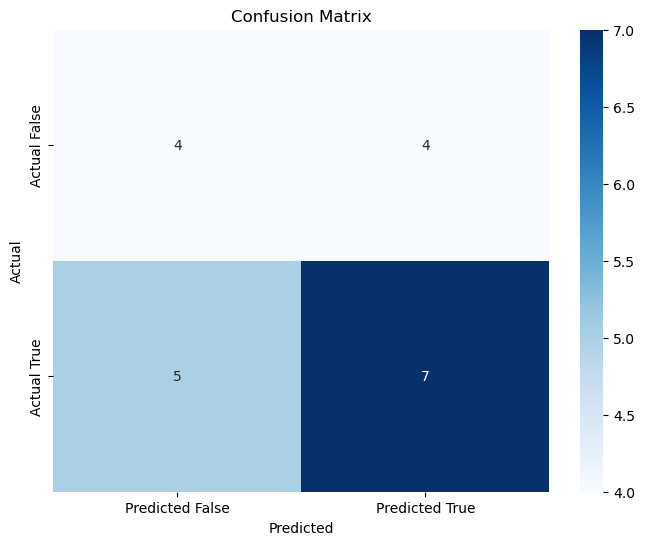

In [215]:
# Integrate two piplelines

# Perform the experiment 100 times
N = 1000

# Lists to store the metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for i in range(N):
    # Use the logistic regression model for audio data
    random_state = int(datetime.datetime.now().timestamp()) % (2**32 - 1) + i
    labels = [label[1] for label in audio_label]
    X_train, X_test, y_train, y_test = train_test_split(features_array, labels, test_size=0.2, random_state=random_state)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    logistic_regression_model = LogisticRegression(max_iter=10000)
    logistic_regression_model.fit(X_train, y_train)
    y_pred_audio = logistic_regression_model.predict_proba(X_test)[:, 1]

    # Use the KMeans model for text data
    encoder = LabelEncoder()
    # Encode labels to numerical values
    labels = [label[0] for label in audio_label]
    encoded_labels = encoder.fit_transform(labels)
    X_train, X_test, y_train, y_test = train_test_split(text_features, encoded_labels, test_size=0.2, random_state=random_state)
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=10000)
    kmeans.fit(X_train)
    y_pred_text = kmeans.predict(X_test)

    # Combine the outputs of the two pipelines
    y_pred_combined = (y_pred_audio + y_pred_text / 2) > 0.5
    accuracy = accuracy_score(y_test, y_pred_combined)
    precision = precision_score(y_test, y_pred_combined)
    recall = recall_score(y_test, y_pred_combined)
    f1 = f1_score(y_test, y_pred_combined)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Calculate the average of each metric
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)

# Print the average metrics
print(f'Average Accuracy over {N} experiments: {avg_accuracy * 100:.2f}%')
print(f'Average Precision: {avg_precision:.2f}')
print(f'Average Recall: {avg_recall:.2f}')
print(f'Average F1-score: {avg_f1:.2f}')
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_combined)

# Convert confusion matrix to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['Actual False', 'Actual True'], columns=['Predicted False', 'Predicted True'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 7 Conclusions

I tried 1000 times of expeirement for each method with time related random seed, to try my best to eliminate the influence of the choice of datasets on the model training process. I can see that the average output of these method is roughly around 50%, and is a little bit better than flipping a coin to decide whether it's true or false. However, I'm pretty glad to see the output of the combined pipeline of these two pipelines, and the result 51.46% is higher than the random guessing by 1.46%.

The first method of performing logistic regression achieved an accuracy of 51.09%, and the second method of performing k-means achieved an accuracy of 50.30%. I can see that that both logistic regression and k-means models perform slightly better than random guessing, which would yield an accuracy of 50%. The logistic regression model shows a marginally better performance compared to the k-means model. However, the improvement is minimal, indicating that distinguishing between true and deceptive stories using these methods is challenging. The ensemble approach, which combines the predictions of both models, shows a slight improvement over individual models, suggesting that it tried to mix the strengths of both models can enhance overall performance. Further optimization and exploration of additional features or models may be necessary to achieve more significant improvements in accuracy. Maybe some aggrasive feature extraction method might be useful, like the wavelet transform, or some other method that can extract the feature of the audio file more accurately, rather than just the frequency component for audio file and the TF-IDF vectorizer for the text file that I'm using now.

# 8 References

- libraries and tools:
    - os and pickle, to store and read pkl files, in order to decrease the amount of time when testing the model, to cut off the time of loading and pre-process the data again and again.
    - numpy, for numerical operations
    - pandas, for data manipulation
    - librosa, for audio processing
    - sklearn, for splitting the dataset, logistic regression model, evaluating the model
    - datetime, for the generation of random seed 
    - whisper, for transfering the audio to text
- websites:
    - CSDN, the page about basic principles and implementation of K Means and logistic regression.